In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def importance(modelo,num):
    xgb_fea_imp=pd.DataFrame(list(modelo.get_booster().get_score().items()),
    columns=['Caracteristica','importancia']).sort_values('importancia', ascending=False)
    print('',xgb_fea_imp)
    xgb_fea_imp.to_csv('xgb_feat_imp'+str(num)+'.cvs')

    from xgboost import plot_importance
    
    ax = plot_importance(modelo, )
    ax.figure.savefig('xgb_feat_imp'+str(num)+'png')

def Openfile(nombre):
    a=pd.read_pickle(nombre)
    a=a[['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']]
    return  a
def clasification(signal,bkgnd):
    bkgnd['signal/bkgnd'] = 0
    signal['signal/bkgnd'] = 1
    df=pd.concat([signal,bkgnd])
    return df
def sets(df,signal,bkgnd):
    train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus (signal/bkgnd and masses)
    train_y = df['signal/bkgnd'] 
    
    signal_x = signal.drop(['signal/bkgnd'], axis=1) 
    signal_y = signal['signal/bkgnd']
    
    bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
    bkgnd_y = bkgnd['signal/bkgnd']

    train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.5, 
                                                  random_state=1)
    train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                      test_size=0.5, 
                                                      random_state=1)
    
    test_x = test_signal_x.append(test_bkgnd_x)
    test_y = test_signal_y.append(test_bkgnd_y)
    
    train_x = train_signal_x.append(train_bkgnd_x)
    train_y = train_signal_y.append(train_bkgnd_y)
    return test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y
def prediction(model,test_signal_x,test_signal_y,test_bkgnd_x,test_bkgnd_y,train_signal_x,train_bkgnd_x):
    predict_signal_test =  model.predict_proba(test_signal_x)[:,1]
    predict_signal_train =  model.predict_proba(train_signal_x)[:,1]
    
    predict_back_test = model.predict_proba(test_bkgnd_x)[:,1]
    predict_back_train = model.predict_proba(train_bkgnd_x)[:,1]
    return predict_signal_test,predict_signal_train,predict_back_test,predict_back_train

def signaloverfit(predict_signal_test,predict_signal_train):
    plt.figure(figsize=(10,7))
    plt.title('Signal overfit')
    m = plt.hist(predict_signal_test, bins=20, label='Test', color='olive')
    plt.hist(predict_signal_train, bins=m[1], label='Train', 
             histtype='stepfilled', facecolor='none', edgecolor='red',
            hatch='////')
    plt.legend(fontsize=13)
    plt.yscale('log')
    plt.show()
    return 0
def overfitting(predict_signal_test,predict_signal_train,predict_back_test,predict_back_train):
    plt.figure(figsize=(10,7))
    plt.title('Overfitting')
    m = plt.hist(predict_signal_test, bins=20, label='Test Signal', facecolor='lightgreen', edgecolor="darkgreen",
                 histtype='stepfilled', alpha=0.8)
    train = np.histogram(predict_signal_train, bins=m[1])
    bins_ = (train[1][1:]+train[1][:-1])/2
    plt.errorbar(bins_, train[0],yerr=np.sqrt(train[0]), 
                     fmt='s', marker='o' ,color='darkgreen',
                    barsabove=False, capsize=5, label='Train Signal')
    
    plt.hist(predict_back_test, bins=m[1], label='Test Background',
                 histtype='stepfilled', facecolor='none', edgecolor='crimson', hatch= '\\\\', alpha=0.8)
    train2 = np.histogram(predict_back_train, bins=m[1])
    bins_2 = (train2[1][1:]+train2[1][:-1])/2
    plt.errorbar(bins_2, train2[0],yerr=np.sqrt(train[0]), 
                     fmt='s', marker='o' ,color='red',
                    barsabove=False, capsize=5, label='Train Background')
    plt.legend(fontsize=13)
    plt.yscale('log')
    plt.ylim(1, 200000)
    plt.xlim(0, 1)
    plt.ylabel('Events', fontsize=13)
    plt.xlabel('XGBoost output', fontsize=13)
    plt.show()

    return 0
def roc(test_x,test_y,train_x,train_y):
    plt.figure(figsize=(10,7))
    plt.title('ROC curve', fontsize=13)
    model_predict = model.predict_proba(test_x)
    model_predict = model_predict[:,1]
    auc_score = roc_auc_score(test_y, model_predict) 
    fpr, tpr, _ = roc_curve(test_y, model_predict) #roc_curve(true binary labels, prediction scores)
    print('Test : ', auc_score)
    plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score, 4)), color='purple')
    
    model_predict = model.predict_proba(train_x)
    model_predict = model_predict[:,1]
    auc_score = roc_auc_score(train_y, model_predict)
    fpr, tpr, _ = roc_curve(train_y, model_predict)
    plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score,4)) , color='orange', linewidth=3)
    print('Train : ', auc_score)
    plt.legend(fontsize=13)
    plt.ylabel('background rejection', fontsize=13)
    plt.xlabel('Signal efficiency', fontsize=13)
    plt.show() 

    return 0

In [2]:
signal=Openfile('5_signal.pkl')
bkgnd=Openfile('5_back.pkl')
df=clasification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
model = xgb.XGBClassifier(objective = 'binary:logistic', 
                              max_depth=6, 
                              learning_rate=0.3,
                             reg_lambda=1000)
model.fit(train_x, train_y)

predict_signal = model.predict(test_x)
print(np.round(accuracy_score(test_y,predict_signal)*100, 2),'%')

predict_signal_test,predict_signal_train,predict_back_test,predict_back_train=prediction(model,test_signal_x,test_signal_y,test_bkgnd_x,test_bkgnd_y,train_signal_x,train_bkgnd_x)



96.55 %


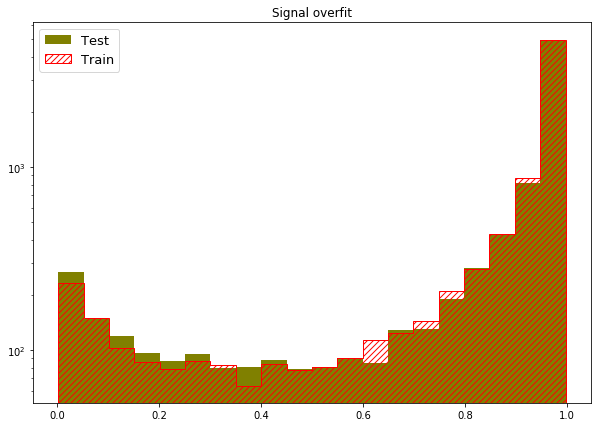

0

In [3]:
signaloverfit(predict_signal_test,predict_signal_train)

In [ ]:

overfitting(predict_signal_test,predict_signal_train,predict_back_test,predict_back_train)


In [ ]:
roc(test_x,test_y,train_x,train_y)